In [1]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from calendar import day_abbr, month_abbr, mdays

## Read data

In [4]:
import pandas as pd

fuzhou_path = '/home/aistudio/data/fuzhou_hourly_modified.xlsx'
singapore_path = '/home/aistudio/data/singapore_hourly_modified.xlsx'

def read_city_data(file_path):
    data = pd.read_excel(file_path, index_col=0, parse_dates=True)
    data.index = pd.to_datetime(data.index, dayfirst=True)
    data.sort_index(inplace=True)
    return data

fuzhou_data = read_city_data(fuzhou_path)
singapore_data = read_city_data(singapore_path)


## Figure 3

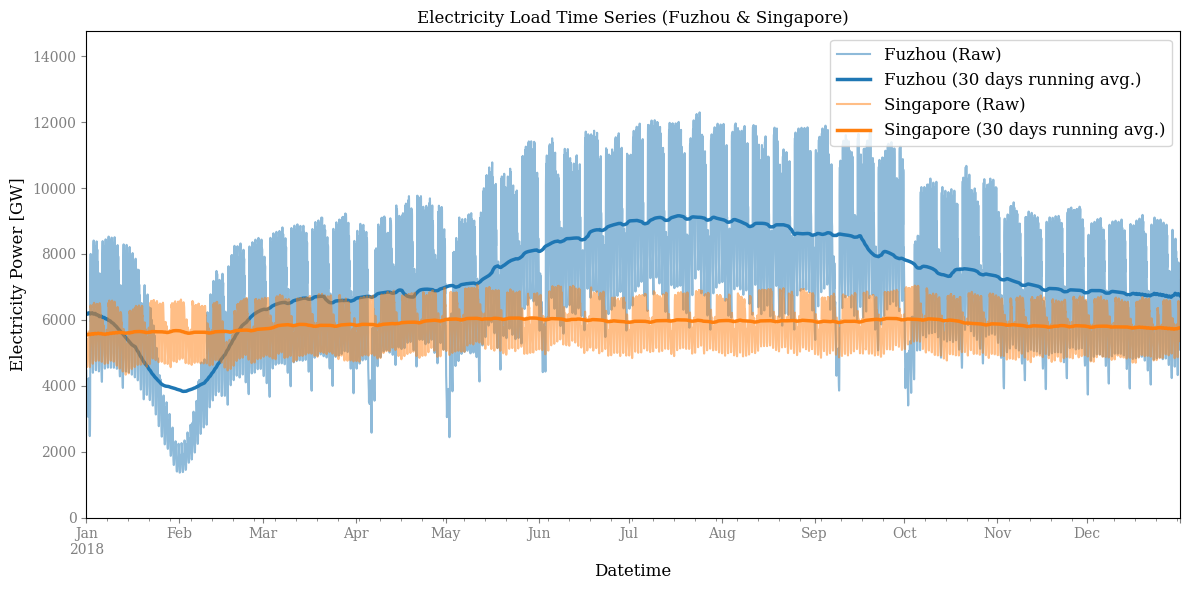

In [5]:
import matplotlib.pyplot as plt

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



f, ax1 = plt.subplots(figsize=(12, 6))

# Fuzhou
fuzhou_data['load'].plot(ax=ax1, color=default_colors[0], alpha=0.5, label='Fuzhou (Raw)')
fuzhou_data['load'].rolling(window=30*24, center=True, min_periods=1).mean().plot(
    ax=ax1, lw=2.5, color=default_colors[0], label='Fuzhou (30 days running avg.)')

# Singapore
singapore_data['load'].plot(ax=ax1, color=default_colors[1], alpha=0.5, label='Singapore (Raw)')
singapore_data['load'].rolling(window=30*24, center=True, min_periods=1).mean().plot(
    ax=ax1, lw=2.5, color=default_colors[1], label='Singapore (30 days running avg.)')

# Y-axis and legend
ax1.set_ylabel('Electricity Power [GW]')
ax1.set_ylim(0, max(fuzhou_data['load'].max(), singapore_data['load'].max()) * 1.2)
ax1.set_title('Electricity Load Time Series (Fuzhou & Singapore)')
ax1.legend(loc='upper right')


plt.tight_layout()
plt.savefig('/home/aistudio/results/figure_fuzhou_singapore.png')
plt.show()


## Figure 4

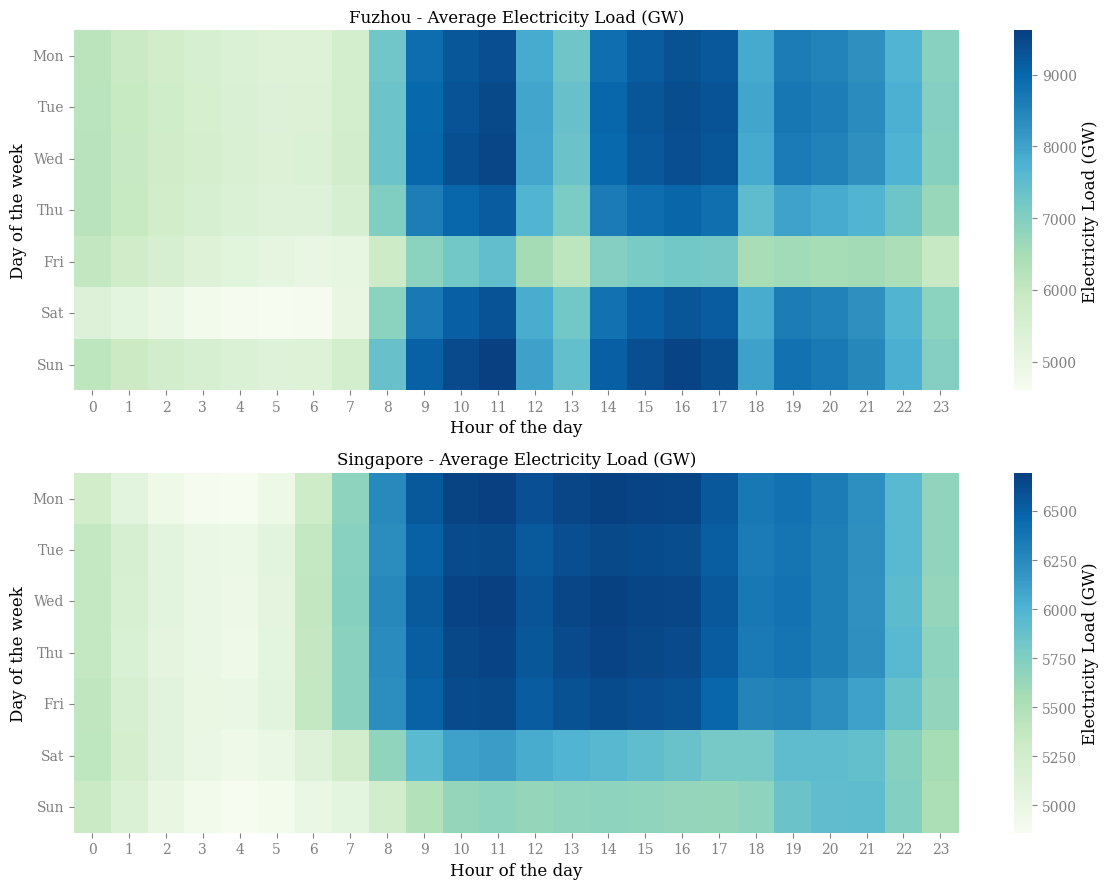

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


day_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


data_dict = {
    0: [fuzhou_data, 'Fuzhou'],
    1: [singapore_data, 'Singapore']
}

fig, axes = plt.subplots(2, 1, figsize=(12, 9))

for i in range(2):
    df = data_dict[i][0]
    city = data_dict[i][1]
    
  
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour


    heatmap_data = df.groupby(['day_of_week', 'hour'])['load'].mean().unstack()
    

    ax = axes[i]
    sns.heatmap(heatmap_data, ax=ax, cmap='GnBu', cbar_kws={'label': 'Electricity Load (GW)'})
    ax.set_title(f'{city} - Average Electricity Load (GW)')
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Day of the week')
    ax.set_yticklabels(day_abbr, rotation=0)


fig.tight_layout()
fig.savefig('/home/aistudio/results/fuzhou_singapore_avg_hour_weekday.png')
plt.show()


In [8]:
def add_holiday_weekend(data):
    '''add holiday, weekend, and non-working day to the dataframe
    '''
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    cal = calendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['Holiday'] = data.index.isin(holidays)

    data['Weekend'] = data.index.weekday > 4
    
    data['Non-workDay'] = data['Holiday'] | data['Weekend']
    data['Day Type'] = data['Non-workDay'].apply(lambda x : 'Non-Working Day' if x else 'Working Day')

    return data

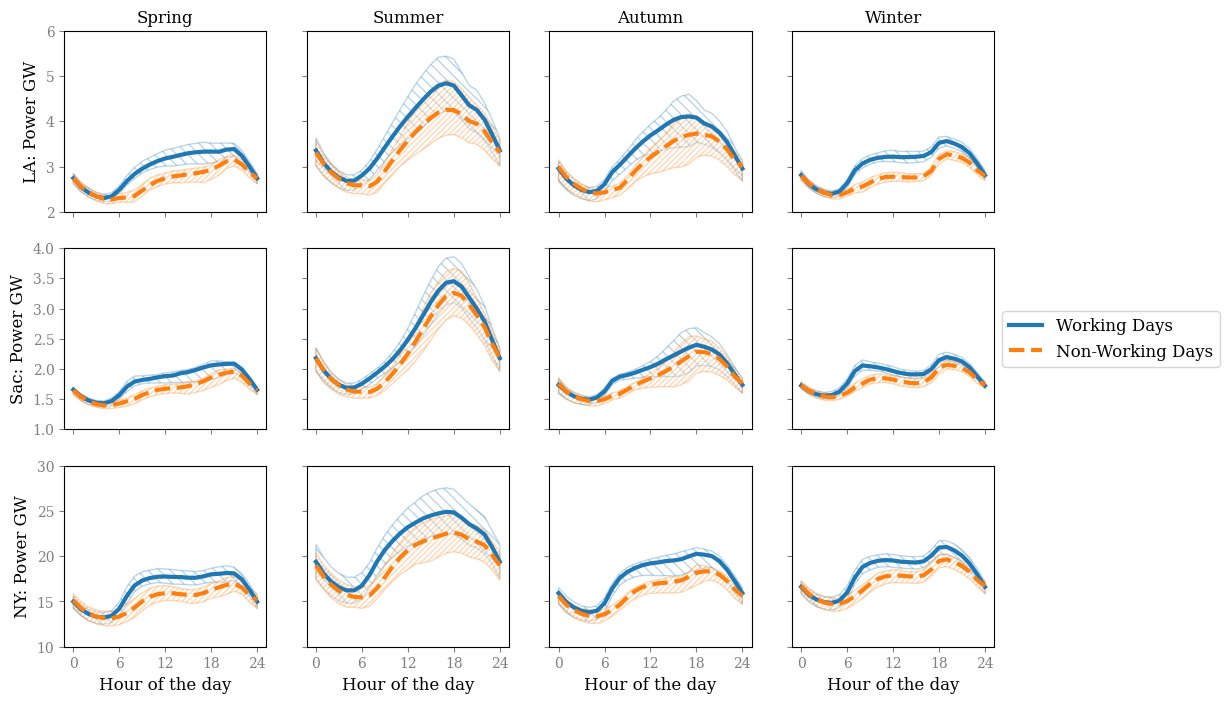

In [10]:
data_dict = {'LADPW': [la, 2, 6],
             'BANC': [sac, 1, 4],
             'NYISO': [ny, 10, 30]}
city_dict = {'LADPW': 'LA',
             'BANC': 'Sac',
             'NYISO': 'NY'}
season_dict = {'Spring': [3,4,5], 'Summer': [6,7,8], 'Autumn': [9, 10, 11], 'Winter': [12, 1, 2]}

fig, axs = plt.subplots(3, 4, figsize=(12,8))



i = 0

for region in data_dict.keys():
    data = data_dict[region][0]
    y_min = data_dict[region][1]
    y_max = data_dict[region][2]
    
    data = add_holiday_weekend(data)

    j = 0
    
    for season in season_dict.keys():
        data_season = data.loc[data.index.month.isin(season_dict[season]), ['load','Day Type']]
        workingday = data_season.loc[data_season['Day Type']=='Working Day', 'load']
        nonworkingday = data_season.loc[data_season['Day Type']=='Non-Working Day', 'load']
        summary_hour_workingday = workingday.groupby(workingday.index.hour).describe()
        summary_hour_nonworkingday = nonworkingday.groupby(nonworkingday.index.hour).describe()
        summary_hour_workingday.loc[24] = summary_hour_workingday.loc[0]
        summary_hour_nonworkingday.loc[24] = summary_hour_nonworkingday.loc[0]
        
        axs[i, j].plot(summary_hour_workingday.index, summary_hour_workingday.loc[:,'mean'], 
                             color=default_colors[0],label='Working Days', lw=3)
        axs[i, j].fill_between(
                 summary_hour_workingday.index.values,
                summary_hour_workingday.loc[:, '25%'].values,
                 summary_hour_workingday.loc[:, '75%'].values,
                 color=default_colors[0], hatch='\\\\\\', facecolor='1', alpha=0.3
                      )

        axs[i, j].plot(
                 summary_hour_nonworkingday.index.values,
                 summary_hour_nonworkingday.loc[:, 'mean'].values,
                 color=default_colors[1], label='Non-Working Days', ls='--', lw=3
                   )

        axs[i, j].fill_between(
                summary_hour_nonworkingday.index.values,
                summary_hour_nonworkingday.loc[:, '25%'].values,
                summary_hour_nonworkingday.loc[:, '75%'].values,
                  color=default_colors[1], hatch='//////', facecolor='1', alpha=0.3
                )        
        axs[i, j].set_ylim([y_min, y_max])
        j += 1
        
    axs[i, 0].set(ylabel=f'{city_dict[region]}: Power GW')
    
    i += 1

for j in range(4):
    axs[0, j].set_title(list(season_dict.keys())[j], fontsize=12)
    

for ax in axs.flat:
    ax.set(xlabel='Hour of the day')
    ax.set_xticks(range(0, 25, 6))
    ax.label_outer()     

axs[2,3].legend(loc='center left', bbox_to_anchor=(1,1.7))

fig.savefig(generate_fig_path('Figure 5'))